In [1]:
#import libraries
 
import pandas as pd
import pyarrow
import pyarrow.parquet
from sklearn.cluster import KMeans

In [2]:
def df_create(file_path) -> pd.DataFrame:
    dtypes = {
        "MMSI": "object",
        "SOG": float,
        "COG": float,
        "Longitude": float,
        "Latitude": float,
        "# Timestamp": "object",
        "Type of mobile": "object",
    }
    usecols = list(dtypes.keys())
    df = pd.read_csv(file_path, usecols=usecols, dtype=dtypes)

    # Remove errors
    bbox = [60, 0, 50, 20]
    north, west, south, east = bbox
    df = df[(df["Latitude"] <= north) & (df["Latitude"] >= south) & (df["Longitude"] >= west) & (
            df["Longitude"] <= east)]
    
    

    df = df[df["Type of mobile"].isin(["Class A", "Class B"])].drop(columns=["Type of mobile"])
    df = df[df["MMSI"].str.len() == 9]  # Adhere to MMSI format
    df = df[df["MMSI"].str[:3].astype(int).between(200, 775)]  # Adhere to MID standard

    df = df.rename(columns={"# Timestamp": "Timestamp"})
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%d/%m/%Y %H:%M:%S", errors="coerce")

    df = df.drop_duplicates(["Timestamp", "MMSI", ], keep="first")

    
    #PABLO --> Should we add this filter, or thats what the Deep Learning model is for? 
    def track_filter(g):
        len_filt = len(g) > 256  # Min required length of track/segment
        sog_filt = 1 <= g["SOG"].max() <= 50  # Remove stationary tracks/segments
        time_filt = (g["Timestamp"].max() - g["Timestamp"].min()).total_seconds() >= 60 * 60  # Min required timespan
        return len_filt and sog_filt and time_filt

    # Track filtering
    df = df.groupby("MMSI").filter(track_filter)
    df = df.sort_values(['MMSI', 'Timestamp'])

    # Divide track into segments based on timegap
    df['Segment'] = df.groupby('MMSI')['Timestamp'].transform(
        lambda x: (x.diff().dt.total_seconds().fillna(0) >= 15 * 60).cumsum())  # Max allowed timegap

    # Segment filtering
    df = df.groupby(["MMSI", "Segment"]).filter(track_filter)
    df = df.reset_index(drop=True)

    #Now we have it in m/s
    knots_to_ms = 0.514444
    df["SOG"] = knots_to_ms * df["SOG"]
    return df

In [3]:
df = df_create("aisdk-2025-10-27.csv")

In [4]:
df2 = df.copy()
df2

,Timestamp,MMSI,Latitude,Longitude,SOG,COG,Segment
0,2025-10-27 00:01:27,203247191,54.793812,9.434017,0.051444,NaN,0
1,2025-10-27 00:04:14,203247191,54.793812,9.434017,0.051444,NaN,0
2,2025-10-27 00:04:28,203247191,54.793788,9.434042,0.000000,NaN,0
3,2025-10-27 00:07:26,203247191,54.793802,9.434013,0.051444,NaN,0
4,2025-10-27 00:10:13,203247191,54.793802,9.434013,0.051444,NaN,0
...,...,...,...,...,...,...,...
6015235,2025-10-27 04:57:18,750399000,55.656063,15.802532,6.327661,76.0,0
6015236,2025-10-27 05:05:08,750399000,55.662467,15.848070,6.276217,74.2,0
6015237,2025-10-27 05:10:26,750399000,55.666983,15.878983,6.276217,75.4,0
6015238,2025-10-27 05:11:26,750399000,55.667863,15.884787,6.276217,75.5,0


In [5]:
# print(df2.head(10))
df2["timestamp_v2"] = df2["Timestamp"].dt.floor(freq='5min')
df2["timestamp_v3"] = df2["Timestamp"].dt.ceil(freq='5min')

round_interval = "10min"

# 1) Columns de redondeo
df2["timestamp_v2"] = pd.to_datetime(df2["Timestamp"], utc=False, errors="coerce").dt.floor(round_interval)
df2["timestamp_v3"] = pd.to_datetime(df2["Timestamp"], utc=False, errors="coerce").dt.ceil(round_interval)

# Orden por MMSI y tiempo real
df2 = df2.sort_values(["MMSI", "Timestamp"])

# 2) Marca primera/última dentro de cada agrupación (MMSI + timestamp_v2)
pos_v2 = df2.groupby(["MMSI", "timestamp_v2"]).cumcount() + 1
cnt_v2 = df2.groupby(["MMSI", "timestamp_v2"])["Timestamp"].transform("size")
keep_v2 = (pos_v2 == 1)

# 3) Marca primera/última dentro de cada agrupación (MMSI + timestamp_v3)
pos_v3 = df2.groupby(["MMSI", "timestamp_v3"]).cumcount() + 1
cnt_v3 = df2.groupby(["MMSI", "timestamp_v3"])["Timestamp"].transform("size")
keep_v3 = (pos_v3 == cnt_v3)
# print(df2.head(10))

# 4) Conserva filas que sean primera/última en v2 o en v3
mask = keep_v2.fillna(False) | keep_v3.fillna(False)
df3 = df2[mask].copy()

In [6]:
df3

,Timestamp,MMSI,Latitude,Longitude,SOG,COG,Segment,timestamp_v2,timestamp_v3
0,2025-10-27 00:01:27,203247191,54.793812,9.434017,0.051444,NaN,0,2025-10-27 00:00:00,2025-10-27 00:10:00
3,2025-10-27 00:07:26,203247191,54.793802,9.434013,0.051444,NaN,0,2025-10-27 00:00:00,2025-10-27 00:10:00
4,2025-10-27 00:10:13,203247191,54.793802,9.434013,0.051444,NaN,0,2025-10-27 00:10:00,2025-10-27 00:20:00
9,2025-10-27 00:19:25,203247191,54.793803,9.434028,0.000000,NaN,0,2025-10-27 00:10:00,2025-10-27 00:20:00
10,2025-10-27 00:22:16,203247191,54.793803,9.434028,0.000000,NaN,0,2025-10-27 00:20:00,2025-10-27 00:30:00
...,...,...,...,...,...,...,...,...,...
6015215,2025-10-27 04:50:08,750399000,55.650130,15.760230,6.379106,75.2,0,2025-10-27 04:50:00,2025-10-27 05:00:00
6015235,2025-10-27 04:57:18,750399000,55.656063,15.802532,6.327661,76.0,0,2025-10-27 04:50:00,2025-10-27 05:00:00
6015236,2025-10-27 05:05:08,750399000,55.662467,15.848070,6.276217,74.2,0,2025-10-27 05:00:00,2025-10-27 05:10:00
6015237,2025-10-27 05:10:26,750399000,55.666983,15.878983,6.276217,75.4,0,2025-10-27 05:10:00,2025-10-27 05:20:00


In [7]:
import pandas as pd
import numpy as np

def interp_prev_next_on_rounded(
    df, n=5,
    value_cols=("Latitude", "Longitude", "SOG", "COG"),
    circular_cols=("COG",),                # columnas angulares (grados)
    group_cols=("MMSI",), ts_col="Timestamp",
    drop_timezone=True,                    # elimina +00:00 al final
):
    def _interp_linear(a, b, r):
        a = pd.to_numeric(a, errors="coerce").to_numpy(dtype=float)
        b = pd.to_numeric(b, errors="coerce").to_numpy(dtype=float)
        r = pd.to_numeric(r, errors="coerce").to_numpy(dtype=float)
        y = a + r * (b - a)
        ok = np.isfinite(a) & np.isfinite(b) & np.isfinite(r)
        y[~ok] = np.nan
        return y

    def _interp_circular_deg(a, b, r):
        # Interpolación circular en grados por el arco más corto
        a = pd.to_numeric(a, errors="coerce").to_numpy(dtype=float)
        b = pd.to_numeric(b, errors="coerce").to_numpy(dtype=float)
        r = pd.to_numeric(r, errors="coerce").to_numpy(dtype=float)
        delta = ( (b - a + 180.0) % 360.0 ) - 180.0
        y = a + r * delta
        y = (y + 360.0) % 360.0
        ok = np.isfinite(a) & np.isfinite(b) & np.isfinite(r)
        y[~ok] = np.nan
        return y

    d = df.copy()
    d[ts_col] = pd.to_datetime(d[ts_col], errors="coerce")
    d = d.sort_values(list(group_cols) + [ts_col])

    # 1) floor/ceil a n minutos
    d["timestamp_v2"] = d[ts_col].dt.floor(f"{n}min")
    d["timestamp_v3"] = d[ts_col].dt.ceil(f"{n}min")

    out = []
    for keys, g in d.groupby(list(group_cols), dropna=False, sort=False):
        g = g.dropna(subset=[ts_col]).sort_values(ts_col)
        if g.empty:
            continue

        # 2) objetivos = union(floor, ceil) dentro del rango observado
        targets = pd.Series(
            pd.concat([g["timestamp_v2"], g["timestamp_v3"]], ignore_index=True)
        ).dropna().unique()
        tmin, tmax = g[ts_col].min(), g[ts_col].max()
        targets = [t for t in targets if (tmin <= t <= tmax)]
        if not targets:
            continue

        tgt = pd.DataFrame({ts_col: sorted(pd.to_datetime(targets))})
        if isinstance(keys, tuple):
            for c, v in zip(group_cols, keys): tgt[c] = v
        else:
            tgt[group_cols[0]] = keys

        base = g[list(group_cols) + [ts_col] + list(value_cols)].sort_values(ts_col)

        # 3) vecino anterior
        prev = pd.merge_asof(
            tgt.sort_values(ts_col),
            base.assign(_t_prev=base[ts_col]),
            on=ts_col, by=list(group_cols), direction="backward"
        ).rename(columns={c: f"{c}_prev" for c in value_cols})

        # vecino posterior
        nxt = pd.merge_asof(
            tgt.sort_values(ts_col),
            base.assign(_t_next=base[ts_col]),
            on=ts_col, by=list(group_cols), direction="forward"
        ).rename(columns={c: f"{c}_next" for c in value_cols})

        m = prev.merge(
            nxt[list(group_cols) + [ts_col, "_t_next"] + [f"{c}_next" for c in value_cols]],
            on=list(group_cols) + [ts_col], how="inner"
        )

        # ratio = (t - t_prev) / (t_next - t_prev)
        num = (m[ts_col] - m["_t_prev"]).dt.total_seconds()
        den = (m["_t_next"] - m["_t_prev"]).dt.total_seconds()
        r = (num / den).where(np.isfinite(num) & np.isfinite(den) & (den != 0))

        # 4) Interpolación: lineal vs circular
        for c in value_cols:
            if c in circular_cols:
                m[c] = _interp_circular_deg(m[f"{c}_prev"], m[f"{c}_next"], r)
            else:
                m[c] = _interp_linear(m[f"{c}_prev"], m[f"{c}_next"], r)

        out.append(m[list(group_cols) + [ts_col] + list(value_cols)])

    if not out:
        res = pd.DataFrame(columns=list(group_cols) + [ts_col] + list(value_cols))
    else:
        res = pd.concat(out, ignore_index=True).sort_values(list(group_cols) + [ts_col])
        res = res.drop_duplicates(subset=list(group_cols) + [ts_col], keep="first")

    # 5) quitar +00:00 (dejar naive) si se pide
    if drop_timezone and not res.empty:
        res[ts_col] = res[ts_col].dt.tz_localize(None)

    return res

# ==== USO (ejemplo) ====
# Interpola cada 10 minutos por MMSI; COG con interpolación circular; sin tz (+00:00 eliminado)
# res = interp_prev_next_on_rounded(df, n=10, group_cols=("MMSI",))
# Si además segmentas:
# res = interp_prev_next_on_rounded(df, n=10, group_cols=("MMSI","Segment"))


# ===== USO =====
# Solo por MMSI, cada 10 min, sin tz (+00:00 eliminado)
res = interp_prev_next_on_rounded(df, n=10, group_cols=("MMSI",))

# Si además segmentas:
# res = interp_prev_next_on_rounded(df, n=10, group_cols=("MMSI","Segment"))
res.to_csv("ais_interpolated.csv", index=False)
res

,MMSI,Timestamp,Latitude,Longitude,SOG,COG
0,203247191,2025-10-27 00:10:00,54.793802,9.434013,0.051444,NaN
1,203247191,2025-10-27 00:20:00,54.793803,9.434028,0.000000,NaN
2,203247191,2025-10-27 00:30:00,54.793801,9.434001,0.024716,NaN
3,203247191,2025-10-27 00:40:00,54.793830,9.433935,0.051444,NaN
4,203247191,2025-10-27 00:50:00,54.793825,9.433992,0.000000,NaN
...,...,...,...,...,...,...
124136,750399000,2025-10-27 04:30:00,55.632529,15.639479,6.584883,74.900000
124137,750399000,2025-10-27 04:40:00,55.641399,15.699847,6.481994,75.027273
124138,750399000,2025-10-27 04:50:00,55.650020,15.759456,6.379106,75.120000
124139,750399000,2025-10-27 05:00:00,55.658270,15.818228,6.309929,75.379574


In [8]:
#Pablo: I have been trying to do it again better withhout success

In [9]:
import numpy as np

def circular_interpolation(angle1, angle2, weight):
    """
    Interpolate between two angles (in degrees) considering circular nature.
    weight: 0 to 1, where 0 returns angle1 and 1 returns angle2
    """
    # Normalize angles to [0, 360)
    angle1 = angle1 % 360
    angle2 = angle2 % 360
    
    # Calculate the shortest angular distance
    diff = angle2 - angle1
    
    # Adjust for circular wraparound
    if diff > 180:
        diff -= 360
    elif diff < -180:
        diff += 360
    
    # Interpolate
    result = (angle1 + weight * diff) % 360
    return result

# List to store new interpolated rows
interpolated_rows = []

# Group by MMSI and process each vessel
for mmsi, group in df3.groupby("MMSI"):
    group = group.sort_values("Timestamp").reset_index(drop=True)
    
    # Check each pair of consecutive rows
    for idx in range(len(group) - 1):
        current_row = group.iloc[idx]
        next_row = group.iloc[idx + 1]
        
        # Check if v3 of current row equals v2 of next row
        if pd.notna(current_row["timestamp_v3"]) and pd.notna(next_row["timestamp_v2"]):
            if current_row["timestamp_v3"] == next_row["timestamp_v2"]:
                # Create interpolated row at timestamp v3
                interpolated_row = current_row.copy()
                interpolated_row["Timestamp"] = current_row["timestamp_v3"]
                
                # Calculate time-based weight
                # weight represents how far the interpolated timestamp is from current to next
                time_total = (next_row["Timestamp"] - current_row["Timestamp"]).total_seconds()
                if time_total > 0:
                    time_from_current = (interpolated_row["Timestamp"] - current_row["Timestamp"]).total_seconds()
                    weight = time_from_current / time_total
                else:
                    weight = 0.5  # default to midpoint if times are equal
                
                # Linear interpolation for Latitude, Longitude, SOG
                # Formula: value = current * (1 - weight) + next * weight
                for col in ["Latitude", "Longitude", "SOG"]:
                    if col in current_row and pd.notna(current_row[col]) and pd.notna(next_row[col]):
                        interpolated_row[col] = current_row[col] * (1 - weight) + next_row[col] * weight
                
                # Circular interpolation for COG
                if "COG" in current_row and pd.notna(current_row["COG"]) and pd.notna(next_row["COG"]):
                    interpolated_row["COG"] = circular_interpolation(
                        current_row["COG"], 
                        next_row["COG"], 
                        weight
                    )
                
                # Mark as interpolated
                interpolated_row["interpolated"] = True
                
                interpolated_rows.append(interpolated_row)

# Create dataframe from interpolated rows
if interpolated_rows:
    df_interpolated = pd.DataFrame(interpolated_rows)
    
    # Combine original data with interpolated rows
    df3["interpolated"] = False
    df_final = pd.concat([df3, df_interpolated], ignore_index=True)
    
    # Sort by MMSI and Timestamp
    df_final = df_final.sort_values(["MMSI", "Timestamp"]).reset_index(drop=True)
else:
    df_final = df3.copy()
    df_final["interpolated"] = False

print(df_final.head(20))
print(f"\nTotal rows: {len(df_final)}")
print(f"Interpolated rows: {df_final['interpolated'].sum()}")

# Show example with timestamps and weights
print(f"\nSample interpolated rows with timestamps:")
sample = df_final[df_final["interpolated"]].head(5)
if len(sample) > 0:
    print(sample[["MMSI", "Timestamp", "Latitude", "Longitude", "SOG", "COG"]])

             Timestamp       MMSI   Latitude  Longitude       SOG  COG  \
0  2025-10-27 00:01:27  203247191  54.793812   9.434017  0.051444  NaN   
1  2025-10-27 00:07:26  203247191  54.793802   9.434013  0.051444  NaN   
2  2025-10-27 00:10:00  203247191  54.793802   9.434013  0.051444  NaN   
3  2025-10-27 00:10:13  203247191  54.793802   9.434013  0.051444  NaN   
4  2025-10-27 00:19:25  203247191  54.793803   9.434028  0.000000  NaN   
5  2025-10-27 00:20:00  203247191  54.793803   9.434028  0.000000  NaN   
6  2025-10-27 00:22:16  203247191  54.793803   9.434028  0.000000  NaN   
7  2025-10-27 00:28:27  203247191  54.793787   9.434005  0.051444  NaN   
8  2025-10-27 00:30:00  203247191  54.793801   9.434001  0.024716  NaN   
9  2025-10-27 00:31:26  203247191  54.793813   9.433998  0.000000  NaN   
10 2025-10-27 00:37:27  203247191  54.793830   9.433935  0.051444  NaN   
11 2025-10-27 00:40:00  203247191  54.793830   9.433935  0.051444  NaN   
12 2025-10-27 00:40:14  203247191  54.

In [10]:
df_10_10 = pd.concat([df3.head(8), df3.tail(12)])

# print(df_10_10)
new_df = pd.DataFrame(columns=df_10_10.columns)
print(new_df)


def lineal_interpolation(a, b, f_a, f_b, y):
    m = (f_b - f_a) / (b - a)
    # print(m)
    return f_a + (y - a) * m

def circular_interpolation(a, b, f_a, f_b, y):
    if abs(f_b - f_a) <= 180:
        # No hay cruce del 0°
        m = (f_b - f_a) / (b - a)
        print(m)
        return f_a + (y - a) * m
    else:
        # print(f_a, f_b)
        if f_a < 180:
            f_a += 360
        elif f_b < 180:
            f_b += 360
        # print(f_a, f_b)
        m = (f_b - f_a) / (b - a)
        ans = f_a + (y - a) * m
        # print(m)
        # print(ans)
        return int(ans % 360)

print()
for a, b in df_10_10.groupby("MMSI"):
    # print(b["Timestamp"])
    for row in range(1, b.shape[0]-1):
        if b.iloc[row]["timestamp_v3"] == b.iloc[row + 1]["timestamp_v2"]:
            timestamp = b.iloc[row]["timestamp_v3"]
            Segment = b.iloc[row]["Segment"]
            latitude = lineal_interpolation(b.iloc[row]["Timestamp"]
            

        
        
        .minute % 10 == 0:
            # print("Row:", row)
            prev_row = b.iloc[row - 1]
            next_row = b.iloc[row + 1]
            current_row = b.iloc[row]
            # print("Prev COG:", prev_row["COG"])
            # print("Next COG:", next_row["COG"])
            interpolated_cog = circular_interpolation(
                prev_row["Timestamp"].minute,
                next_row["Timestamp"].minute,
                prev_row["COG"],
                next_row["COG"],
                current_row["Timestamp"].minute
            )
            print(f"Interpolated COG at {current_row['Timestamp']} for MMSI {a}: {interpolated_cog}")
    print("\n")
    # for row_num, val in b.iterrows():
    #     print(val)
    #     print("\n")




SyntaxError: '(' was never closed (3760000729.py, line 39)

In [ ]:
a = df[df["MMSI"] == '211912000']
a['Segment'].value_counts()

Segment
14    1987
Name: count, dtype: int64

In [ ]:
a.to_excel("output_211912000.xlsx")

NameError: name 'a' is not defined

In [ ]:
import openpyxl
df.tail(50000).to_excel("output_2.xlsx")


                           Timestamp      Latitude     Longitude  \
count                        6015240  6.015240e+06  6.015240e+06   
mean   2025-10-27 12:16:31.847634176  5.614322e+01  1.097053e+01   
min              2025-10-27 00:00:00  5.348157e+01  3.248647e+00   
25%              2025-10-27 06:30:59  5.516090e+01  1.005230e+01   
50%              2025-10-27 12:26:09  5.597331e+01  1.095632e+01   
75%              2025-10-27 18:06:25  5.732118e+01  1.213256e+01   
max              2025-10-27 23:59:58  5.860836e+01  1.866088e+01   
std                              NaN  1.146552e+00  1.951811e+00   

                SOG           COG       Segment  
count  5.999620e+06  5.821995e+06  6.015240e+06  
mean   3.396398e+00  1.826194e+02  2.477399e-01  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  8.520000e+01  0.000000e+00  
50%    3.292442e+00  1.911000e+02  0.000000e+00  
75%    5.710328e+00  2.704000e+02  0.000000e+00  
max    2.278987e+01  3.599000e+02  1.

TypeError: print() got an unexpected keyword argument 'xlabel'

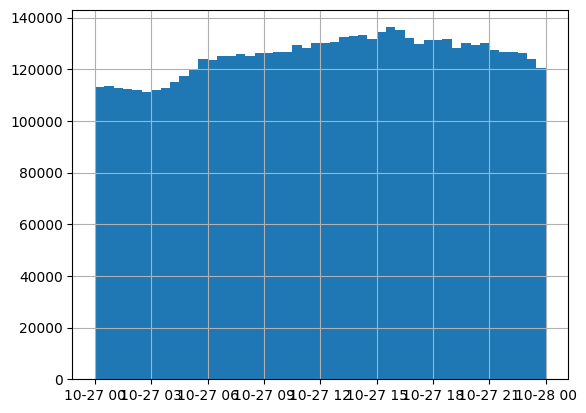

In [ ]:
print(df.describe())
for i in df.columns:
    print(i)
    # print(df[i].describe)

print(df["Timestamp"].hist(bins=48), xlabel="Timestamp")


<Axes: >

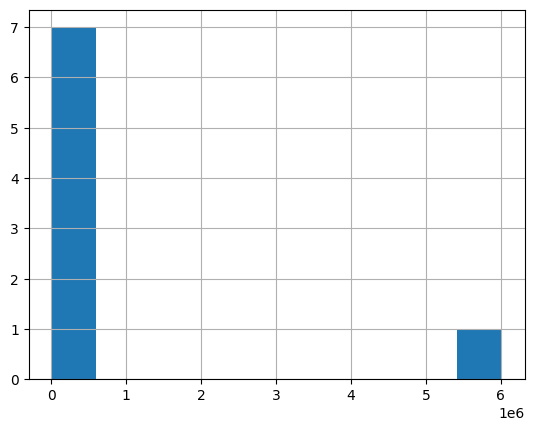

In [ ]:
df["Segment"].describe().hist()

In [ ]:
import pandas as pd

# Archivo único .parquet
df = pd.read_parquet("output.parquet/")

# Dataset particionado (carpetas estilo MMSI=.../Segment=.../)
df = pd.read_parquet("output.parquet/")  # lee todo el dataset

# Columnas concretas y filtro (pushdown si el motor lo soporta)
df = pd.read_parquet(
    "output.parquet/",
    columns=["MMSI","Segment","Latitude","Longitude"],
    filters=[("MMSI","=",211912000), ("Segment","=",14)]
)



In [ ]:




# def fn(file_path, out_path):
#     dtypes = {
#         "MMSI": "object",
#         "SOG": float,
#         "COG": float,
#         "Longitude": float,
#         "Latitude": float,
#         "# Timestamp": "object",
#         "Type of mobile": "object",
#     }
#     usecols = list(dtypes.keys())
#     df = pandas.read_csv(file_path, usecols=usecols, dtype=dtypes)

#     # Remove errors
#     bbox = [60, 0, 50, 20]
#     north, west, south, east = bbox
#     df = df[(df["Latitude"] <= north) & (df["Latitude"] >= south) & (df["Longitude"] >= west) & (
#             df["Longitude"] <= east)]
    
    
#     # df[df["MMSI"] == "211912000"].to_excel("output_211912000_v2.xlsx")  # Remove leading/trailing spaces
#     df = df[df["Type of mobile"].isin(["Class A", "Class B"])].drop(columns=["Type of mobile"])
#     df = df[df["MMSI"].str.len() == 9]  # Adhere to MMSI format
#     df = df[df["MMSI"].str[:3].astype(int).between(200, 775)]  # Adhere to MID standard
